#Problem 1

In [ ]:
!kaggle datasets download -d moltean/fruits


Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

with zipfile.ZipFile("fruits.zip", "r") as zip_ref:
    zip_ref.extractall("fruits")


In [ ]:
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch.nn.functional as F
import torch.nn.init as init

In [ ]:
torch.manual_seed(99)

In [ ]:
class CNN(nn.Module):
  def __init__(self,dr=0.3,added_conv = False,skip = False):#dr:drop out rate
    super().__init__()
    self.skip = skip
    self.added_conv = added_conv
    self.conv1 = nn.Conv2d(3 , 64, kernel_size =(3,3), stride = (1,1))
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
    self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), stride = (1,1))
    if added_conv:
      self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
      self.conv3 = nn.Conv2d(128,256,kernel_size=(3,3), stride = (1,1))
      self.bn = nn.BatchNorm2d(256,momentum=0.99, eps=0.01)
    else:
      self.bn = nn.BatchNorm2d(128,momentum=0.99, eps=0.01)
    self.d = nn.Dropout2d(p=dr)
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
    if skip:
      if added_conv:
        self.skip_layer = nn.Conv2d(3,256,kernel_size=(5,5),stride = (5,5))
      else:
        self.skip_layer = nn.Conv2d(3,128,kernel_size = (9,9),stride = (2,2))
    if added_conv:
      self.fc1 = nn.Linear(12544, 512)
      self.fc2 = nn.Linear(512, 141)
    else:
      self.fc1 = nn.Linear(36992, 256)
      self.fc2 = nn.Linear(256, 141)
  def forward(self,x):
    res = x
    x = self.conv1(x)
    x = F.relu(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    if not self.added_conv:
      if self.skip:
        res = self.skip_layer(res)
        x = res + x
        x = F.relu(x)
      else:
        x = F.relu(x)
    else:
      if self.skip:
        res = self.skip_layer(res)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = x + res
        x = F.relu(x)
      else:
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = F.relu(x)

    x = self.bn(x)
    x = self.d(x)
    x = self.maxpool2(x)
    x = torch.flatten(x, start_dim=1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x




In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)


In [ ]:
from torch.utils.data import random_split, DataLoader
transform = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor()
])
data = ImageFolder(root="fruits/fruits-360_dataset_100x100/fruits-360/Training",\
                   transform = transform)
print(f"There are {len(data.classes)} classes in total")
print(f"There are {len(data)} pictures in total")
train, val = random_split(data, [int(len(data)*0.85),len(data)-int(len(data)*0.85)])
train_loader = DataLoader(train,batch_size = 1000, shuffle=True,drop_last=True,\
                          num_workers=4,generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val,batch_size = 1000,drop_last=True,num_workers=4,\
                        generator=torch.Generator().manual_seed(42))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = nn.CrossEntropyLoss()



There are 141 classes in total
There are 70491 pictures in total


In [ ]:
print(device)

cuda


In [ ]:
    def train(model,epochs,optimizer):
        #Train
        model.apply(initialize_weights)
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        for i in range(epochs):
          model.train()
          train_loss = 0
          correct = 0
          total = 0
          for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(images)
            _, predicted = torch.max(out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            l = loss(out,labels)
            l.backward()
            optimizer.step()
            train_loss += l
          train_loss = train_loss/len(train_loader)
          train_losses.append(train_loss)
          train_acc = correct/total
          train_accs.append(train_acc)
          correct = 0
          total = 0
          model.eval()
          with torch.no_grad():
            val_loss = 0
            num_batches = len(val_loader)
            for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs, 1)
              val_loss += loss(outputs,labels).item()
              correct += (predicted == labels).sum().item()
              total += labels.size(0)

            val_loss = val_loss/num_batches
            val_acc = correct/total
            val_losses.append(val_loss)
            val_accs.append(val_acc)
          print(f"epoch {i+1}: train loss: {train_loss:.5f} train acc: {train_acc:.5f} \
          val loss: {val_loss:.5f} val acc: {val_acc:.5f}")

        return train_losses,val_losses,train_accs,val_accs

In [ ]:
    from collections import defaultdict

    def trainAll(dropOutRate = [0.1, 0.3, 0.5],isSkip = False,\
                 added_conv1 = False, epochs=20):
        models = defaultdict(CNN)
        train_losses = defaultdict(list)
        val_losses = defaultdict(list)
        train_accs = defaultdict(list)
        val_accs = defaultdict(list)

        for i in dropOutRate:
          print("-"*15+f"Training CNN, dropOutRate = {i}, "+\
                f"epochs = {epochs}"+"-"*15)
          if isSkip:
            print("Added a residual connection")
          else:
            print("No residual connection")
          if added_conv1:
            print("Added a maxpooling layer and a convolutional layer")
          else:
            print("Didn't add the convolutional layer, using the \
            default architecture")
          models[i] = CNN(dr = i, added_conv=added_conv1,skip = isSkip)
          models[i].to(device)
          optimizer = optim.Adam(models[i].parameters(), lr = 0.001)
          train_losses[i],val_losses[i],train_accs[i],val_accs[i] = \
          train(models[i],epochs,optimizer)
          print("Training done!")
        return models, train_accs, val_accs, val_losses, train_losses
    def test(model,testloader,device):
          correct, total = 0, 0
          model.eval()
          for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
          return correct/total




#CNN without adding residual connection and convolutional layer

In [ ]:
models, train_accs, val_accs, val_losses, train_losses = trainAll()

---------------Training CNN, dropOutRate = 0.1, epochs = 20---------------
No residual connection
Didn't add the convolutional layer, using the default architecture
epoch 1: train loss: 0.81086 train acc: 0.81942 val loss: 0.01184 val acc: 0.99830
epoch 2: train loss: 0.00923 train acc: 0.99764 val loss: 0.02375 val acc: 0.99520
epoch 3: train loss: 0.00518 train acc: 0.99878 val loss: 0.00350 val acc: 0.99960
epoch 4: train loss: 0.00068 train acc: 0.99993 val loss: 0.00307 val acc: 0.99960
epoch 5: train loss: 0.00025 train acc: 0.99998 val loss: 0.00277 val acc: 0.99980
epoch 6: train loss: 0.01284 train acc: 0.99753 val loss: 0.16060 val acc: 0.96540
epoch 7: train loss: 0.05253 train acc: 0.98544 val loss: 0.01128 val acc: 0.99690
epoch 8: train loss: 0.00767 train acc: 0.99785 val loss: 0.00482 val acc: 0.99950
epoch 9: train loss: 0.00080 train acc: 0.99978 val loss: 0.00366 val acc: 0.99960
epoch 10: train loss: 0.00019 train acc: 0.99997 val loss: 0.00337 val acc: 0.99980
epoc

In [ ]:
dropOutRate = [0.1, 0.3, 0.5]


# Effect of Dropout Rate on Model Performance

We evalutated the effect of different dropout rates on the model’s validation accuracy, training accuracy, and test accuracy. The dropout rates tested were **0.1, 0.3, and 0.5**.

## Results Summary

| Dropout Rate | Validation Accuracy | Training Accuracy | Test Accuracy |
|-------------|---------------------|-------------------|--------------|
| **0.1**     | 0.99880             | 0.99502           | 0.95230      |
| **0.3**     | 0.99890             | 0.99624           | 0.95404      |
| **0.5**     | 0.99920             | 0.99688           | 0.96161      |

## Observations

### 1. Validation Accuracy
- Validation accuracy remains consistently high across all dropout rates, increasing slightly as dropout increases.
- At a dropout rate of 0.5, the model achieves the highest validation accuracy of 0.99920.

### 2. Training Accuracy
- Training accuracy also increases with dropout, reaching 0.99688 at dropout = 0.5.
- This suggests that the model still maintains strong learning ability despite increased regularization.

### 3. Test Accuracy (Generalization Performance)
- The test accuracy increases with higher dropout, improving from 0.95230 (dropout = 0.1) to 0.96161 (dropout = 0.5).
- This trend suggests that higher dropout helps reduce overfitting, leading to better generalization on unseen data.

## Conclusion
The results indicate that increasing dropout improves both training and test performance, which align with its functionality of reducing over-fitting. The highest test accuracy (0.96161) is achieved at dropout = 0.5, indicating that this dropout rate offers the best balance between training performance and generalization.



In [ ]:
TestData = ImageFolder(root="fruits/fruits-360_dataset_100x100/fruits-360/Test", \
                       transform = transform)
for i in dropOutRate:
  print("-"*65)
  print(f"When dropOutRate = {i}, the final validation accuracy = {val_accs[i][-1]:.5f}")
  print(f"When dropOutRate = {i}, the final training accuracy = {train_accs[i][-1]:.5f}")
  m = models[i]
  TestLoader = DataLoader(TestData,batch_size = 1000, shuffle=True,drop_last=True,\
                          num_workers=4,generator=torch.Generator().manual_seed(42))
  acc = test(m,TestLoader,device)
  print(f"When dropOutRate = {i}, test accuracy = {acc:.5f}")



-----------------------------------------------------------------
When dropOutRate = 0.1, the final validation accuracy = 0.99880
When dropOutRate = 0.1, the final training accuracy = 0.99502
When dropOutRate = 0.1, test accuracy = 0.95230
-----------------------------------------------------------------
When dropOutRate = 0.3, the final validation accuracy = 0.99890
When dropOutRate = 0.3, the final training accuracy = 0.99624
When dropOutRate = 0.3, test accuracy = 0.95404
-----------------------------------------------------------------
When dropOutRate = 0.5, the final validation accuracy = 0.99920
When dropOutRate = 0.5, the final training accuracy = 0.99688
When dropOutRate = 0.5, test accuracy = 0.96161


##Loss Curves During Training
###We also plotted and compared the training process of the loss curves. As we can infer from the below graphs, all the three dropout rates converged very fast during the training. However, having a higher dropout rate seem to be more stable during the training. For example, when dropout rate = 0.1, there exist some peak of loss during the training, indicating that the model is overfitting. When the dropout rate increases to 0.3, this problem reduce a lot. When it increases to 0.5, we can barely see such kind of sudden increase of loss during the training process, which align with our previous conclusion that by using the dropout technique we can reduce the overfitting.

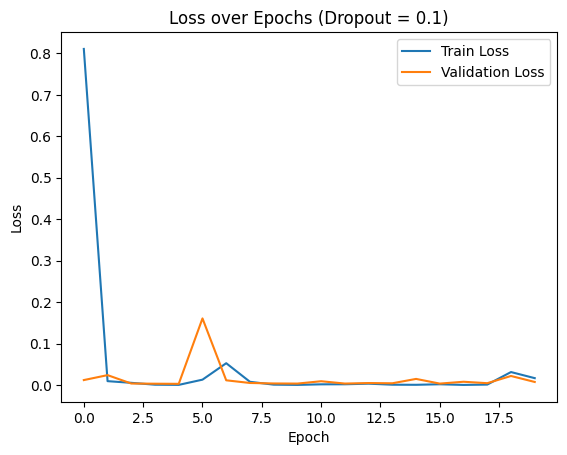

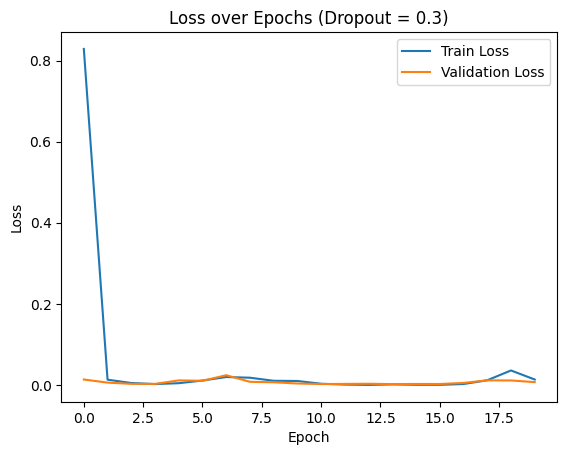

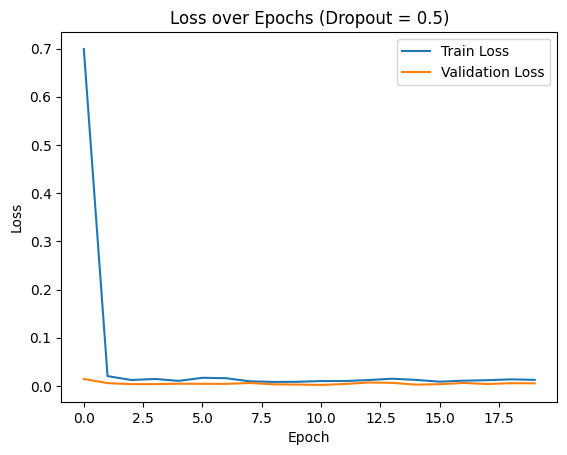

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
for i in dropOutRate:
  train_losses_cpu = [val.cpu().item() if \
  isinstance(val, torch.Tensor) else val for val in train_losses[i]]
  val_losses_cpu = [val.cpu().item() if \
  isinstance(val, torch.Tensor) else val for val in val_losses[i]]
  x = np.arange(len(train_losses_cpu))
  plt.plot(x, train_losses_cpu,label="Train Loss")
  plt.plot(x, val_losses_cpu,label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f"Loss over Epochs (Dropout = {i})")
  plt.legend()
  plt.show()


#Added a Maxpooling Layer and a Convolutional Layer


In [ ]:
models0, train_accs0, val_accs0, val_losses0, train_losses0 = \
trainAll(dropOutRate = [0.3],isSkip = False, added_conv1 = True, epochs=20)

---------------Training CNN, dropOutRate = 0.3, epochs = 20---------------
No residual connection
Added a maxpooling layer and a convolutional layer
epoch 1: train loss: 0.62303 train acc: 0.84566 val loss: 0.04354 val acc: 0.98500
epoch 2: train loss: 0.02480 train acc: 0.99300 val loss: 0.04339 val acc: 0.98700
epoch 3: train loss: 0.02616 train acc: 0.99246 val loss: 0.00957 val acc: 0.99750
epoch 4: train loss: 0.03959 train acc: 0.99068 val loss: 0.02653 val acc: 0.99240
epoch 5: train loss: 0.00928 train acc: 0.99702 val loss: 0.00376 val acc: 0.99910
epoch 6: train loss: 0.00383 train acc: 0.99880 val loss: 0.00272 val acc: 0.99970
epoch 7: train loss: 0.00859 train acc: 0.99783 val loss: 0.03082 val acc: 0.99570
epoch 8: train loss: 0.00836 train acc: 0.99795 val loss: 0.00748 val acc: 0.99850
epoch 9: train loss: 0.06180 train acc: 0.98646 val loss: 0.07112 val acc: 0.98540
epoch 10: train loss: 0.06641 train acc: 0.98749 val loss: 0.04380 val acc: 0.99070
epoch 11: train loss

## Effect of an Additional Convolutional Layer on Model Performance

This experiment examines the impact of adding a convolutional layer on the model's performance.

## Results

### Without Additional Convolutional Layer
| Dropout Rate | Validation Accuracy | Training Accuracy | Test Accuracy |
|-------------|---------------------|-------------------|--------------|
| 0.3         | 0.99890             | 0.99624           | 0.95404      |

### With Additional Convolutional Layer
| Dropout Rate | Validation Accuracy | Training Accuracy | Test Accuracy |
|-------------|---------------------|-------------------|--------------|
| 0.3         | 0.99940             | 0.99763           | 0.96357      |


### Impact of Adding a Convolutional Layer
- Validation accuracy increased from 0.99890 to 0.99940, showing a small improvement.
- Training accuracy increased from 0.99624 to 0.99763, indicating a better ability to fit the training data.
- Test accuracy improved significantly from 0.95404 to 0.96357, suggesting that the additional convolutional layer helped the model extract better features and generalize better to unseen data.

## Conclusion

- Adding a convolutional layer improves both training and test accuracy, demonstrating the benefit of deeper feature extraction.
- The test accuracy increased by 0.95%, indicating a significant improvement in generalization.

In [ ]:
print("-"*65)
print("Added a convolutional layer")
print(f"When dropOutRate = 0.3, the final validation accuracy = \
{val_accs0[0.3][-1]:.5f}")
print(f"When dropOutRate = 0.3, the final training accuracy = \
{train_accs0[0.3][-1]:.5f}")
m0 = models0[0.3]
TestLoader = DataLoader(TestData,batch_size = 1000, shuffle=True,drop_last=True,\
                num_workers=4,generator=torch.Generator().manual_seed(42))
acc0 = test(m0,TestLoader,device)
print(f"When dropOutRate = 0.3, test accuracy = {acc0:.5f}")

-----------------------------------------------------------------
Added a convolutional layer
When dropOutRate = 0.3, the final validation accuracy = 0.99940
When dropOutRate = 0.3, the final training accuracy = 0.99763
When dropOutRate = 0.3, test accuracy = 0.96357


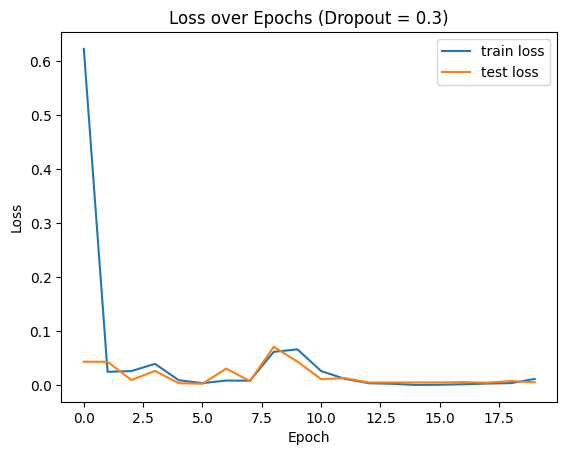

In [ ]:
train_losses_cpu0 = [val.cpu().item() if \
isinstance(val, torch.Tensor) else val for val in train_losses0[0.3]]
val_losses_cpu0 = [val.cpu().item() if \
isinstance(val, torch.Tensor) else val for val in val_losses0[0.3]]
x0 = np.arange(len(train_losses_cpu0))
plt.plot(x0, train_losses_cpu0,label = "train loss")
plt.plot(x0, val_losses_cpu0,label = "test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss over Epochs (Dropout = 0.3)")
plt.legend()
plt.show()

#Added a residual connection from the input to the output of the second convolutional layer

In [ ]:
models1, train_accs1, val_accs1, val_losses1, train_losses1 = \
trainAll(dropOutRate = [0.3],isSkip = True, added_conv1 = False, epochs=20)

---------------Training CNN, dropOutRate = 0.3, epochs = 20---------------
Added a residual connection
Didn't add the convolutional layer, using the default architecture
epoch 1: train loss: 0.93734 train acc: 0.77661 val loss: 0.02090 val acc: 0.99470
epoch 2: train loss: 0.02562 train acc: 0.99266 val loss: 0.00549 val acc: 0.99900
epoch 3: train loss: 0.00923 train acc: 0.99778 val loss: 0.00323 val acc: 0.99970
epoch 4: train loss: 0.00745 train acc: 0.99819 val loss: 0.00538 val acc: 0.99840
epoch 5: train loss: 0.00692 train acc: 0.99810 val loss: 0.00544 val acc: 0.99840
epoch 6: train loss: 0.00830 train acc: 0.99797 val loss: 0.00301 val acc: 0.99970
epoch 7: train loss: 0.00535 train acc: 0.99864 val loss: 0.00256 val acc: 0.99950
epoch 8: train loss: 0.02049 train acc: 0.99400 val loss: 0.01299 val acc: 0.99620
epoch 9: train loss: 0.01931 train acc: 0.99400 val loss: 0.00610 val acc: 0.99860
epoch 10: train loss: 0.03875 train acc: 0.98934 val loss: 0.00951 val acc: 0.99760

# Effect of Residual Connection on Model Performance

This experiment examines the impact of adding a residual connection on the model's performance.

## Results Summary

### Without Residual Connection
| Dropout Rate | Validation Accuracy | Training Accuracy | Test Accuracy |
|-------------|---------------------|-------------------|--------------|
| **0.3**     | **0.99890**         | **0.99624**       | **0.95404**  |

### With Residual Connection
| Dropout Rate | Validation Accuracy | Training Accuracy | Test Accuracy |
|-------------|---------------------|-------------------|--------------|
| **0.3**     | **0.99940**         | **0.99810**       | **0.95026**  |


## Impact of Adding a Residual Connection
- Validation accuracy increased from 0.99890 to 0.99940, showing a slight improvement.
- Training accuracy increased significantly from 0.99624 to 0.99810, indicating that the model is fitting the training data more effectively.
- Test accuracy, however, decreased from 0.95404 to 0.95026, suggesting that while the residual connection helped training performance, it may have reduced generalization.

## Conclusion
- Adding a residual connection improves training accuracy but slightly decreases test accuracy, which may indicate a reduction in regularization and an increased tendency to overfit.
- Further investigation is needed to balance the benefits of residual connections with generalization to unseen data.

These results suggest that while architectural changes like residual connections can enhance training performance, their impact on test accuracy should be carefully analyzed.


In [ ]:
print("-"*65)
print("Added a residual connection")
print(f"When dropOutRate = 0.3, the final validation accuracy = \
{val_accs1[0.3][-1]:.5f}")
print(f"When dropOutRate = 0.3, the final training accuracy = \
{train_accs1[0.3][-1]:.5f}")
m1 = models1[0.3]
TestLoader = DataLoader(TestData,batch_size = 1000, shuffle=True,\
        drop_last=True,num_workers=4,generator=torch.Generator().manual_seed(42))
acc1 = test(m1,TestLoader,device)
print(f"When dropOutRate = 0.3, test accuracy = {acc1:.5f}")

-----------------------------------------------------------------
Added a residual connection
When dropOutRate = 0.3, the final validation accuracy = 0.99940
When dropOutRate = 0.3, the final training accuracy = 0.99810
When dropOutRate = 0.3, test accuracy = 0.95026


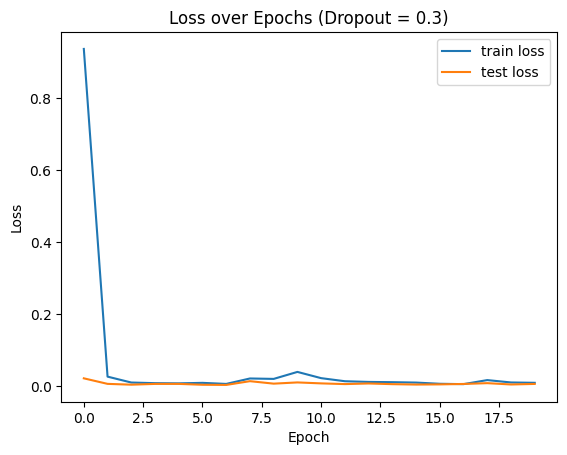

In [ ]:
train_losses_cpu1 = [val.cpu().item() if \
isinstance(val, torch.Tensor) else val for val in train_losses1[0.3]]
val_losses_cpu1 = [val.cpu().item() if \
isinstance(val, torch.Tensor) else val for val in val_losses1[0.3]]
x0 = np.arange(len(train_losses_cpu1))
plt.plot(x0, train_losses_cpu1,label = "train loss")
plt.plot(x0, val_losses_cpu1,label = "test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss over Epochs (Dropout = 0.3)")
plt.legend()
plt.show()

#Problem 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, \
      GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_size = 2000
maxlen = 300
embedding_dim = 16
batch_size = 32
epochs = 30
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
# Randomly shuffle
shuffle_indices = np.random.permutation(len(x_train))
x_train = np.array(x_train)[shuffle_indices]
y_train = np.array(y_train)[shuffle_indices]
# Pad
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

x_val = x_train[:1000]
y_val = y_train[:1000]
x_train_partial = x_train[1000:]
y_train_partial = y_train[1000:]


In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    Conv1D(filters=128, kernel_size=3, activation='relu', strides=1, padding='valid'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(x_train_partial, y_train_partial,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)





Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6638 - loss: 0.5821 - val_accuracy: 0.8330 - val_loss: 0.3728
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8552 - loss: 0.3383 - val_accuracy: 0.8600 - val_loss: 0.3144
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8898 - loss: 0.2589 - val_accuracy: 0.8660 - val_loss: 0.3092
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9160 - loss: 0.2200 - val_accuracy: 0.8650 - val_loss: 0.3082
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9315 - loss: 0.1828 - val_accuracy: 0.8780 - val_loss: 0.3023
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9447 - loss: 0.1559 - val_accuracy: 0.8640 - val_loss: 0.3264
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9559 - loss: 0.1280 - val_accuracy: 0.8540 - val_loss: 0.3494
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9683 - loss: 0.1068 - val_accuracy: 0.

##Model Performance of the 1-D CNN for Sentiment Analysis

The final accuracy of the model is 0.85668. Although this result is somehow not bad, as we could infer form those two graphs below (accuracy curves and loss curves), the model is experiencing over-fitting.

During training, the model’s accuracy quickly reaches almost 100 percent. However, at the same time, the validation accuracy stabilizes around 80–85% and doesn’t show significant improvement over time. This suggests that while the model has learned the training set very well, it is not generalizing well to unseen data.

When looking at the loss values, the training loss decrease steadily and eventually becomes very low (near 0). On the other hand, the validation loss, although it initially drops, begins to rise as the epochs go up.This also align well with our observation from the accuracy curves.

From these observations, it is clear that the model is overfitting. This situation is further highlighted by the validation accuracy reaching a plateau early on, which implies that the model finds a limit to how well it can predict outcomes on new data once it has already captured the more obvious patterns in the training set.

To summarize, those accuracy and loss curves shows that the model fits the training data extremely well but overfits, as indicated by the rising validation loss and plateauing validation accuracy. This might due to the model is too complex, while the training data is not sufficient. In the next section, we will apply several techniques to try to address those issues.







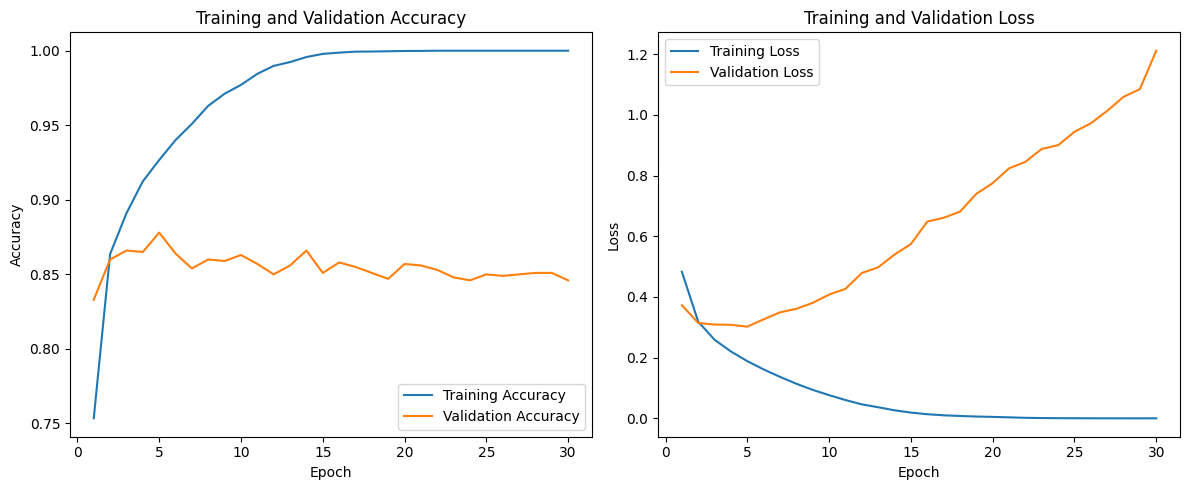

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


##Optimizing the Model to Achieve Better Performance
In order to reduce over-fitting, we tried to integrate following approaches into the model:
- Using a larger dropout rate after the embedding layer.
- Using larger kernel size.
- Training for more epochs and use early stopping.
- Use L2 regularization for training.

The reasons why we design those techniques are as follows.

1. Dropout helps prevent the model from relying too heavily on specific neurons, forcing it to learn more generalizable features. By increasing the dropout rate after the embedding layer, we ensure that the model does not memorize individual word embeddings but rather captures robust patterns across different reviews.

2. A larger kernel size allows the model to capture long-range dependencies in text data, which can be beneficial for sentiment analysis where relevant words may not always be adjacent.This helps the model extract more abstract, high-level representations, reducing sensitivity to noise and specific word placements.

3. Training for a higher number of epochs enables the model to converge and fully learn the underlying patterns in the data. However, excessive training can also lead to overfitting. To address this, we use early stopping, which monitors validation loss and stop training if the model starts overfitting to the training set.

4. L2 regularization can penalize large weights by adding a small term to the loss function that discourages complex models.

By using these techniques, we were able to achieve an accuracy of 0.87423, which is a 2% increase compared to the original model architecture and training design.

The loss curves and accuracy curves are shown below. As we can see, by applying these techniques, the overfitting problem is mitigated to a large extent. However, the increase in performance is still not significant. This might be due to the inherent limitation of the dataset's size. With more training data, we could potentially achieve even higher accuracy for the model.




Training optimized model...
Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6068 - loss: 0.6531 - val_accuracy: 0.8150 - val_loss: 0.4331
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8165 - loss: 0.4296 - val_accuracy: 0.8530 - val_loss: 0.3742
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8418 - loss: 0.3848 - val_accuracy: 0.8570 - val_loss: 0.3567
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8589 - loss: 0.3489 - val_accuracy: 0.8570 - val_loss: 0.3522
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8636 - loss: 0.3401 - val_accuracy: 0.8590 - val_loss: 0.3410
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8745 - loss: 0.3203 - val_accuracy: 0.8600 - val_loss: 0.3341
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8693 - loss: 0.3247 - val_accuracy: 0.8630 - val_loss: 0.3289
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.87

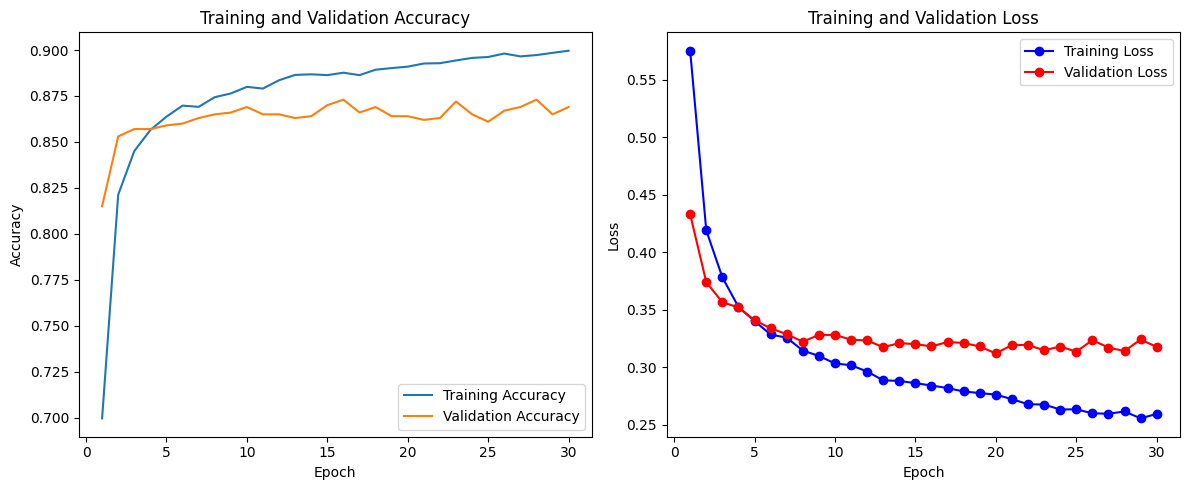

In [ ]:
batch_size = 32
epochs = 100


(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
x_val = x_train[:1000]
y_val = y_train[:1000]
x_train_partial = x_train[1000:]
y_train_partial = y_train[1000:]
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    Dropout(0.5),
    Conv1D(filters=128, kernel_size=8, activation='relu', strides=2, padding='valid'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train_partial, y_train_partial,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,  label='Training Accuracy')
plt.plot(epochs_range, val_acc,  label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
